In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0) 
torch.manual_seed(0)

# torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
train = pd.read_csv("data/goodreads_train.csv")
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [3]:
train.shape

(900000, 11)

In [4]:
len(train["user_id"].unique()), len(train["book_id"].unique())

(12188, 25474)

In [5]:
train["user_id"].isna().sum()

0

In [6]:
train["book_id"].isna().sum()

0

In [7]:
test = pd.read_csv("data/goodreads_test.csv")
test.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,Thu Nov 01 00:28:39 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Thu Nov 01 00:00:00 -0700 2012,0,0
4,b9450d1c1f97f891c392b1105959b56e,12551082,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,Thu Oct 18 00:57:00 -0700 2012,Mon Apr 01 23:00:51 -0700 2013,Sat Mar 30 00:00:00 -0700 2013,Fri Mar 29 00:00:00 -0700 2013,0,0


In [8]:
test.shape

(478033, 10)

In [9]:
train.shape, test.shape

((900000, 11), (478033, 10))

In [10]:
# new users in test
len(set(test["user_id"]) - set(train["user_id"]))

6704

In [11]:
# new books in test
len(set(test["book_id"]) - set(train["book_id"]))

1

In [12]:
X = train.loc[:, ["user_id", "book_id"]]

In [13]:
# encode user and book ids
enc = OrdinalEncoder(handle_unknown="use_encoded_value",
                                   unknown_value=-1)
X = enc.fit_transform(X)
X[:5, :]

array([[ 6441., 15888.],
       [ 6441.,   711.],
       [ 6441., 23330.],
       [ 6441., 22615.],
       [ 6441., 21991.]])

In [14]:
# add 1 to X_train, so unknowns would be 0
X = X + 1
X.min()

1.0

In [15]:
train["rating"].isna().sum()

0

<AxesSubplot: ylabel='Frequency'>

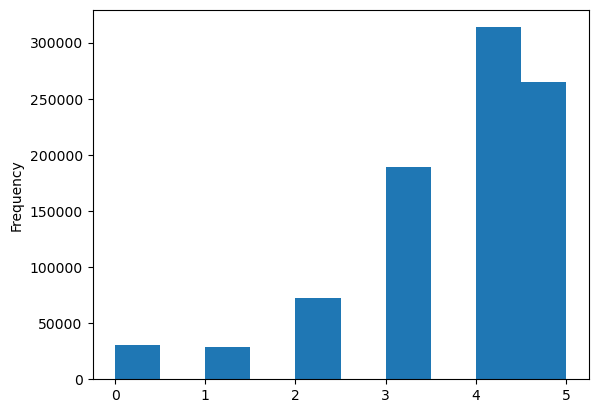

In [16]:
train["rating"].plot.hist()

In [17]:
y = train["rating"].values
y[:5]

array([5, 3, 3, 0, 4], dtype=int64)

In [18]:
# create a validation set
x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, random_state=0)

print(x_train.shape, x_valid.shape)

(675000, 2) (225000, 2)


In [19]:
# Dataset
class CollabDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [20]:
train_ds = CollabDataset(x_train, y_train)
valid_ds = CollabDataset(x_valid, y_valid)

In [21]:
bs = 2048
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

x_batch, y_batch = next(iter(train_dl))
x_batch.shape, y_batch.shape

(torch.Size([2048, 2]), torch.Size([2048]))

In [22]:
def create_params(size):
    # helper function for creating embeddings
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [23]:
class CollabModel(nn.Module):
    def __init__(self, n_users, n_books, n_factors=50, y_range=(0, 5.5)):
        super().__init__()
        self.user_embs = create_params([n_users, n_factors])
        self.book_embs = create_params([n_books, n_factors])
        self.user_bias = create_params([n_users])
        self.book_bias = create_params([n_books])
        self.y_range = y_range
        
    def forward(self, x):
        # first col: users, second col: books
        x_users = self.user_embs[x[:, 0]]
        x_books = self.book_embs[x[:, 1]]
        b_users = self.user_bias[x[:, 0]]
        b_books = self.book_bias[x[:, 1]]
        
        # dot product
        y_hat = (x_users * x_books).sum(dim=1)
        
        # add biases
        y_hat = y_hat + b_users + b_books
        
        # make y_hat in y_range
        y_hat = self.y_range[0] + (self.y_range[1]-self.y_range[0]) * torch.sigmoid(y_hat)
        
        return y_hat

In [24]:
# save one for unkowns
n_users, n_books = x_train.max(axis=0)+1

model = CollabModel(int(n_users), int(n_books))

In [25]:
model(x_batch.long()).shape

torch.Size([2048])

In [26]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

Layer: user_embs | Size: torch.Size([12189, 50])
Layer: book_embs | Size: torch.Size([25475, 50])
Layer: user_bias | Size: torch.Size([12189])
Layer: book_bias | Size: torch.Size([25475])


In [27]:
def train(model, train_dl, valid_dl, epochs, lr, wd):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss()
    history = defaultdict(list)
    model.to(device)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        
        train_loss = 0
        nsamples_train = 0
        
        for x_batch, y_batch in tqdm(train_dl, leave=False):
            optimizer.zero_grad()
            y_hat = model(x_batch.long().to(device))
            
            loss = criterion(y_hat, y_batch.float().to(device))
            loss.backward()
            optimizer.step()
            
            batch_size = x_batch.shape[0]
            nsamples_train += batch_size
            train_loss += loss.item() * batch_size
            
        valid_loss = 0
        nsamples_valid = 0
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in tqdm(valid_dl, leave=False):
                y_hat = model(x_batch.type(torch.LongTensor).to(device))
                loss = criterion(y_hat, y_batch.to(device))

                batch_size = x_batch.shape[0]
                nsamples_valid += batch_size
                valid_loss += loss.item() * batch_size
        
        history["train"].append(train_loss/nsamples_train)
        history["valid"].append(valid_loss/nsamples_valid)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}: train loss {train_loss/nsamples_train};'
                  f'valid loss {valid_loss/nsamples_valid}')
            
    return model, history

In [28]:
lr = 2e-5
epochs = 100
wd = 0.1
model, losses = train(model, train_dl, valid_dl, epochs=epochs, lr=lr, wd=wd)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10: train loss 2.337519254178648;valid loss 2.3322155876074895


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 20: train loss 2.2177039690427427;valid loss 2.2190513685268827


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 30: train loss 2.070810798413312;valid loss 2.0805364816708036


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 40: train loss 1.8936313560584739;valid loss 1.9154307686360676


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 50: train loss 1.715668930478979;valid loss 1.7526567881181505


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 60: train loss 1.5631501485697428;valid loss 1.616492677078247


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 70: train loss 1.4448482873648185;valid loss 1.5140688058132596


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 80: train loss 1.3566621187393753;valid loss 1.440547895634969


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 90: train loss 1.2906187590591995;valid loss 1.3879830426194932


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 100: train loss 1.2398461679501003;valid loss 1.349736300040351


<AxesSubplot: >

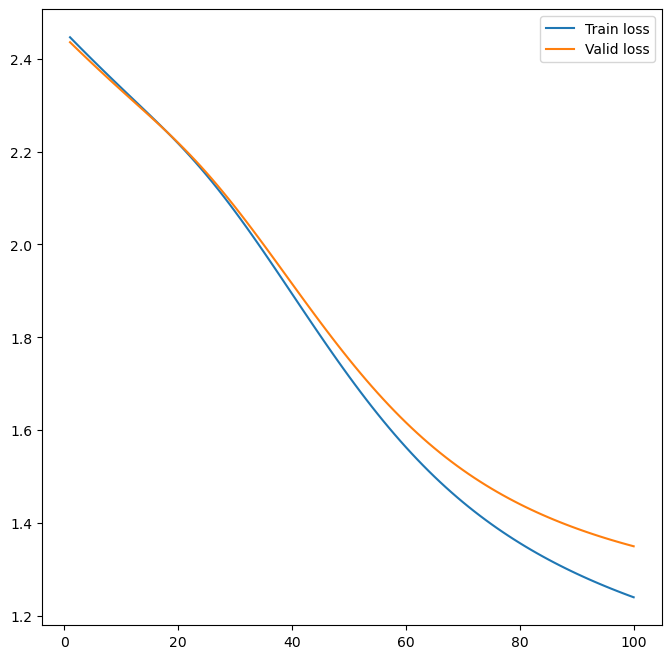

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.lineplot(x=range(1, epochs+1), y=losses["train"], ax=ax, label="Train loss")
sns.lineplot(x=range(1, epochs+1), y=losses["valid"], ax=ax, label="Valid loss")

In [32]:
x_test = test.loc[:, ["user_id", "book_id"]]
x_test = enc.transform(x_test) + 1
x_test

array([[ 8806.,  6285.],
       [ 8806.,  5188.],
       [ 8806., 12226.],
       ...,
       [    0.,  5372.],
       [    0.,  8313.],
       [    0.,  5733.]])

In [35]:
y_test = np.zeros(len(x_test))

In [37]:
test_ds = CollabDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, drop_last=False)

In [38]:
def test(model, test_dl):
    preds = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_dl, leave=False):
            y_hat = model(x_batch.type(torch.LongTensor).to(device))
            preds.append(y_hat)
    return preds

In [39]:
preds = test(model,test_dl)
len(preds)

  0%|          | 0/234 [00:00<?, ?it/s]

234

In [40]:
preds = torch.cat(preds, dim=0)
preds.shape

torch.Size([478033])

In [43]:
preds = preds.cpu().numpy()
preds[:5]

array([3.3667698, 3.163784 , 3.5814865, 3.5053744, 3.3544655],
      dtype=float32)

In [45]:
sub = pd.read_csv("data/goodreads_sample_submission.csv")
sub.head()

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,0
1,8eaeaf13213eeb16ad879a2a2591bbe5,0
2,dce649b733c153ba5363a0413cac988f,0
3,8a46df0bb997269d6834f9437a4b0a77,0
4,d11d3091e22f1cf3cb865598de197599,0


In [48]:
sub["rating"] = preds
sub["rating"] = sub["rating"].astype(int)
sub.head()

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,3
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,3
3,8a46df0bb997269d6834f9437a4b0a77,3
4,d11d3091e22f1cf3cb865598de197599,3


<AxesSubplot: ylabel='Frequency'>

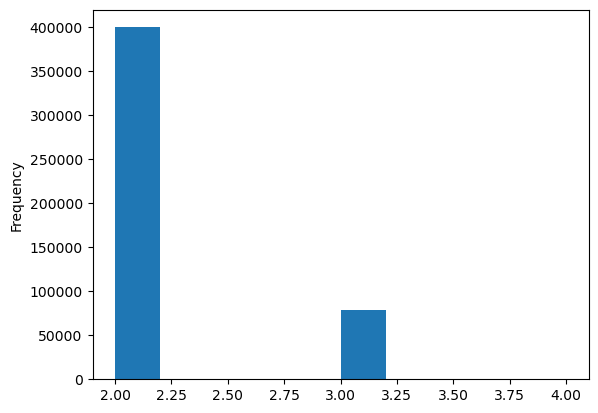

In [50]:
sub["rating"].plot.hist()

In [ ]:
sub.to_csv("data/preds_v1.csv", index=False)